# Mapa da coleta -plotly
lento no render

In [1]:
import geopandas as gpd
import pandas as pd
import os
import json
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.features import GeoJson, GeoJsonTooltip

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*choropleth_mapbox.*deprecated.*")


In [2]:
# leitura da geometria de coleta
filename="shape_coleta.gpkg"
path='/home/akel/PycharmProjects/Data_ambiental/data/process/'
arquivo = os.path.join(path, filename)

gdf = gpd.read_file(arquivo)

gdf['num_dias'] = gdf['dias'].apply(lambda x: len(eval(x)))
gdf=gdf[['area_coleta',	'setor','horario',	'dias',	'num_dias','latitude_ref','longitude_ref',	'geometry']]
gdf.head(5)

,area_coleta,setor,horario,dias,num_dias,latitude_ref,longitude_ref,geometry
0,231,1406,noturno,"[1, 2, 3, 4, 5, 6]",6,-1.457621,-48.488588,"POLYGON ((-48.48221 -1.45644, -48.48225 -1.456..."
1,287,1305,diurno,"[1, 2, 3, 4, 5, 6]",6,-1.475703,-48.474152,"POLYGON ((-48.47705 -1.47251, -48.47623 -1.471..."
2,215,1307,diurno,"[1, 2, 3, 4, 5, 6]",6,-1.475703,-48.465140,"POLYGON ((-48.46102 -1.47104, -48.46169 -1.471..."
3,242,1301,diurno,"[1, 2, 3, 4, 5, 6]",6,-1.474577,-48.497808,"POLYGON ((-48.50046 -1.46973, -48.49938 -1.467..."
4,253,1302,diurno,"[1, 2, 3, 4, 5, 6]",6,-1.472325,-48.486543,"POLYGON ((-48.48374 -1.46823, -48.48416 -1.469..."


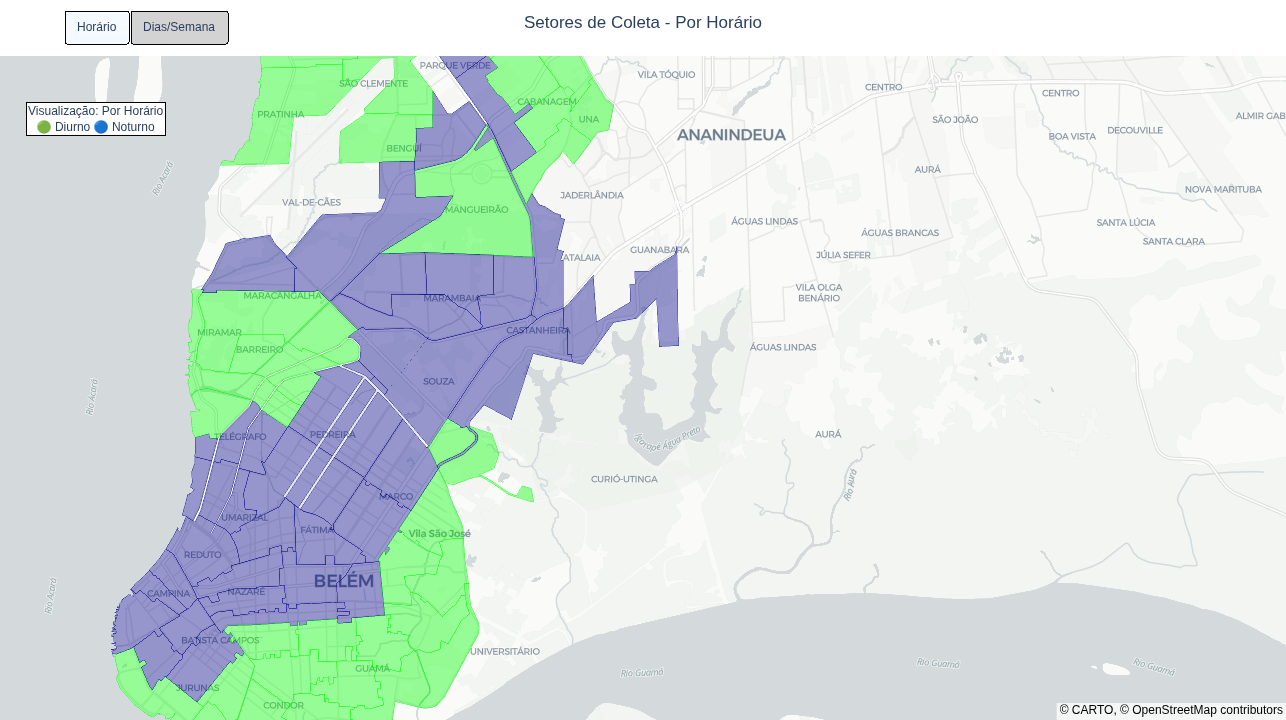

Wait expired, Browser is being closed by watchdog.


In [4]:
#lento na renderização
# -----------------------------------------------------
# MAPA COM BOTÕES HORIZONTAIS PARA ALTERNAR ENTRE HORARIO E NUM_DIAS
# -----------------------------------------------------
centro_lat, centro_lon = -1.417897, -48.4162631

# Simplificar geometrias para performance
gdf_simplified = gdf.copy()
#gdf_simplified['geometry'] = gdf_simplified['geometry'].simplify(tolerance=0.0005, preserve_topology=True)

# Criar figura
fig = go.Figure()

# Definir esquemas de cores
color_schemes = {
    'horario': {
        'diurno': {'fill': 'rgba(0, 255, 0, 0.4)', 'line': 'green'},
        'noturno': {'fill': 'rgba(0, 0, 139, 0.4)', 'line': 'darkblue'}
    },
    'num_dias': {
        3: {'fill': 'rgba(255, 165, 0, 0.4)', 'line': 'orange'},      # Laranja para 3 dias
        6: {'fill': 'rgba(0, 255, 0, 0.4)', 'line': 'green'},         # Verde para 6 dias
        'default': {'fill': 'rgba(100, 100, 100, 0.4)', 'line': 'gray'}  # Cinza para outros
    }
}

# Lista para controlar a visibilidade
variaveis = ['horario', 'num_dias']
visibility_states = {
    'horario': [True, False] * len(gdf_simplified),    # Primeiro visível
    'num_dias': [False, True] * len(gdf_simplified)    # Segundo invisível
}

# Adicionar todos os polígonos
for idx, row in gdf_simplified.iterrows():
    if row.geometry.geom_type == 'Polygon':
        # Extrair coordenadas do polígono
        x, y = row.geometry.exterior.xy
        lons = list(x)
        lats = list(y)
        
        # Pular polígonos muito complexos
        if len(lons) > 200:
            continue
            
        # Formatar dias da semana
        dias_semana = {1: 'Seg', 2: 'Ter', 3: 'Qua', 4: 'Qui', 5: 'Sex', 6: 'Sáb', 7: 'Dom'}
        dias_coleta = [dias_semana.get(dia, str(dia)) for dia in row.dias]
        dias_str = ', '.join(dias_coleta)
        
        # Texto do hover
        hover_text = f"""
        <b>Setor: {row.setor}</b><br>
        Área: {row.area_coleta}<br>
        Horário: {row.horario}<br>
        Dias: {dias_str}<br>
        Dias/Semana: {row.num_dias}<br>
        Lat: {row.latitude_ref:.4f}<br>
        Lon: {row.longitude_ref:.4f}
        """
        
        # Cores para horario
        horario_color = color_schemes['horario'].get(row.horario, 
                    {'fill': 'rgba(100, 100, 100, 0.4)', 'line': 'gray'})
        
        # Cores para num_dias
        num_dias_color = color_schemes['num_dias'].get(row.num_dias, 
                     color_schemes['num_dias']['default'])
        
        # Adicionar traço para visualização por horario (visível inicialmente)
        fig.add_trace(go.Scattermap(
            lat=lats,
            lon=lons,
            mode='lines',
            fill='toself',
            name=f"Setor {row.setor}",
            text=hover_text,
            hoverinfo='text',
            line=dict(width=0),
            fillcolor=horario_color['fill'],
            showlegend=False,
            visible=True  # Visível inicialmente
        ))
        
        # Adicionar traço para visualização por num_dias (invisível inicialmente)
        fig.add_trace(go.Scattermap(
            lat=lats,
            lon=lons,
            mode='lines',
            fill='toself',
            name=f"Setor {row.setor}",
            text=hover_text,
            hoverinfo='text',
            line=dict(width=0),
            fillcolor=num_dias_color['fill'],
            showlegend=False,
            visible=False  # Invisível inicialmente
        ))

# Criar botões HORIZONTAIS no estilo do código 1
buttons = []
for i, var in enumerate(variaveis):
    # Definir visibilidade para este botão
    visibility = visibility_states[var]
    
    # Definir título e legenda baseado na variável
    if var == 'horario':
        title = "Setores de Coleta - Por Horário "
        legend_text = "Por Horário 🕐 <br>🟢 Diurno 🔵 Noturno"
    else:
        title = "Setores de Coleta - Por Dias da Semana " 
        legend_text = "Por Dias/Semana 📅<br>🟠 3 dias 🟢 6 dias"
    
    buttons.append(
        dict(
            label="Horário" if var == 'horario' else "Dias/Semana",
            method="update",
            args=[
                {"visible": visibility},
                {
                    "title": title,
                    "annotations": [dict(
                        text=legend_text,
                        x=0.02, y=0.98, xref="paper", yref="paper",
                        showarrow=False, bgcolor="white", bordercolor="black", 
                        borderwidth=1
                    )] }] ))
    

# Configurar layout do mapa COM BOTÕES HORIZONTAIS
fig.update_layout(
    map_style="carto-positron",
    map_center={"lat": centro_lat, "lon": centro_lon},
    map_zoom=12,
    # Botões horizontais acima do mapa (estilo código 1)
    updatemenus=[
        dict(
            type="buttons",
            direction="right",  # Direção horizontal
            buttons=buttons,
            x=0.05,  # Posição inicial
            y=1.02,  # Acima do mapa
            xanchor="left",
            yanchor="bottom",
            bgcolor="lightgray",
            bordercolor="black",
            borderwidth=1,
            pad={"r": 10, "t": 10},
            showactive=True
        )
    ],
    height=720,
    margin={"r": 0, "t": 50, "l": 0, "b": 0},  # Margem superior para os botões
    title={
        'text': "Setores de Coleta - Por Horário",
        'x': 0.5,
        'xanchor': 'center'
    },
    annotations=[dict(
        text="Visualização: Por Horário<br>🟢 Diurno 🔵 Noturno",
        x=0.02, y=0.93, xref="paper", yref="paper",
        showarrow=False, bgcolor="white", bordercolor="black", borderwidth=1
    )]
)

fig.show(config={"scrollZoom": True})
